<a href="https://colab.research.google.com/github/gayathrisaxena/Blog/blob/main/Gayathri%20saxena_skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d bhanuprasanna/isic-2019

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
403 - Forbidden - Permission 'datasets.get' was denied


In [2]:
! unzip /content/isic-2019.zip

unzip:  cannot find or open /content/isic-2019.zip, /content/isic-2019.zip.zip or /content/isic-2019.zip.ZIP.


In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [4]:
os.mkdir('/content/small_data')

In [11]:
import os
import random
import shutil

dataset_dir = '/content/ISIC - 2019'
train_dir = os.path.join(dataset_dir, 'train')
small_train_dir = '/content/small_data/small_train'

# Check if the train directory exists
if os.path.exists(train_dir):
    subclasses = os.listdir(train_dir)

    # Create the small_train directory if it doesn't exist
    os.makedirs(small_train_dir, exist_ok=True)

    subset_size = 74
    random.seed(42)

    for subclass in subclasses:
        subclass_dir = os.path.join(train_dir, subclass)
        small_train_subclass_dir = os.path.join(small_train_dir, subclass)
        os.makedirs(small_train_subclass_dir, exist_ok=True)

        image_files = os.listdir(subclass_dir)

        # Select a subset of image files
        subset_files = random.sample(image_files, subset_size)

        for file in subset_files:
            src_path = os.path.join(subclass_dir, file)
            dst_path = os.path.join(small_train_subclass_dir, file)
            shutil.copyfile(src_path, dst_path)

else:
    print(f"Directory {train_dir} not found!")


Directory /content/ISIC - 2019/train not found!


In [12]:
import os
import random
import shutil

dataset_dir = '/content/ISIC - 2019'
val_dir = os.path.join(dataset_dir, 'val')
small_val_dir = '/content/small_data/small_val'

subset_size = 22
random.seed(42)

# Check if the val directory exists
if os.path.exists(val_dir):
    os.makedirs(small_val_dir, exist_ok=True)

    subclasses = os.listdir(val_dir)

    for subclass in subclasses:
        subclass_dir = os.path.join(val_dir, subclass)
        small_val_subclass_dir = os.path.join(small_val_dir, subclass)
        os.makedirs(small_val_subclass_dir, exist_ok=True)

        image_files = os.listdir(subclass_dir)

        # Ensure there are enough image files to sample
        if len(image_files) >= subset_size:
            subset_files = random.sample(image_files, subset_size)
        else:
            print(f"Warning: Not enough images in {subclass_dir} to sample {subset_size} images. Using all images.")
            subset_files = image_files

        # Copy the selected files to the small_val directory
        for file in subset_files:
            src_path = os.path.join(subclass_dir, file)
            dst_path = os.path.join(small_val_subclass_dir, file)
            shutil.copyfile(src_path, dst_path)

else:
    print(f"Directory {val_dir} not found!")


Directory /content/ISIC - 2019/val not found!


# BALANCE


In [14]:
if os.path.exists(train_dir):
    class_subdirs = os.listdir(train_dir)
    class_names = []
    sample_counts = []

    for class_subdir in class_subdirs:
        class_dir = os.path.join(train_dir, class_subdir)
        if os.path.isdir(class_dir):
            sample_count = len(os.listdir(class_dir))

            class_names.append(class_subdir)
            sample_counts.append(sample_count)

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, sample_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Target Class Distribution before augmentation')

    for i, count in enumerate(sample_counts):
        plt.text(i, count + 10, str(count), ha='center')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"Directory {train_dir} not found!")


Directory /content/ISIC - 2019/train not found!


In [17]:
import os
import glob
import random

def delete_images_randomly(directory, num_images_to_delete):
    # Get a list of all image files in the directory
    image_files = glob.glob(os.path.join(directory, "*.jpg"))

    # Check if the number of images to delete is within the available range
    num_images_to_delete = min(num_images_to_delete, len(image_files))

    # Shuffle the list of images randomly
    random.shuffle(image_files)

    # Delete the specified number of images
    for i in range(num_images_to_delete):
        try:
            os.remove(image_files[i])
            print(f"Deleted: {image_files[i]}")
        except OSError as e:
            print(f"Error deleting {image_files[i]}: {e}")

# Example usage
import os
import glob
import random

def delete_images_randomly(directory, num_images_to_delete):
    # Get a list of all image files in the directory
    image_files = glob.glob(os.path.join(directory, "*.jpg"))

    # Check if the number of images to delete is within the available range
    num_images_to_delete = min(num_images_to_delete, len(image_files))

    # Shuffle the list of images randomly
    random.shuffle(image_files)

    # Delete the specified number of images
    for i in range(num_images_to_delete):
        try:
            os.remove(image_files[i])
            print(f"Deleted: {image_files[i]}")
        except OSError as e:
            print(f"Error deleting {image_files[i]}: {e}")

# Example usage
directory_to_clean = '/content/ISIC - 2019/train/Melanocytic nevus'

num_images_to_delete = 10 # Change this to the desired number of images to delete

delete_images_randomly(directory_to_clean, num_images_to_delete)


In [19]:
import os
import random
import keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Define the path to the main dataset folder containing train, val, and test folders
main_folder = "/content/ISIC - 2019/train"

# Define the target number of images per class
target_count = 5000

# Function to perform data augmentation
def augment_images(src_folder, target_count):
    if not os.path.exists(src_folder):
        print(f"Folder {src_folder} does not exist.")
        return

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png", ".jpg", ".jpeg"))]
    total_images = len(image_files)

    datagen = ImageDataGenerator(
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5)
    )

    while total_images < target_count:
        # Randomly select an image from the class folder
        random_image = random.choice(image_files)
        src_path = os.path.join(src_folder, random_image)

        # Read the image using Keras
        img = load_img(src_path)

        x = img_to_array(img)
        # Reshaping the input image
        x = x.reshape((1, ) + x.shape)

        # Generating and saving augmented samples
        i = 0
        total_images += 5
        for batch in datagen.flow(x, batch_size = 1, save_to_dir = src_folder, save_prefix ='image', save_format ='jpg'):
            i += 1
            if i > 5:
                break

# Function to process all classes in the main dataset folder
def process_classes(main_folder):
    if not os.path.exists(main_folder):
        print(f"Directory {main_folder} does not exist.")
        return

    class_folders = [os.path.join(main_folder, folder) for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

    for class_folder in class_folders:
        class_images = [f for f in os.listdir(class_folder) if f.endswith((".jpg"))]
        images_count = len(class_images)
        if images_count < target_count:
            print(f"Augmenting images in class folder: {class_folder}")
            augment_images(class_folder, target_count)

# Process all classes in the main dataset folder
if os.path.exists(main_folder):
    process_classes(main_folder)
else:
    print(f"Directory {main_folder} does not exist.")


Directory /content/ISIC - 2019/train does not exist.


In [21]:
import os
import matplotlib.pyplot as plt

dataset_dir = '/content/ISIC - 2019'
train_dir = os.path.join(dataset_dir, 'train')

# Check if the train directory exists
if not os.path.exists(train_dir):
    print(f"Error: Directory {train_dir} does not exist.")
else:
    class_subdirs = os.listdir(train_dir)

    class_names = []
    sample_counts = []

    for class_subdir in class_subdirs:
        class_dir = os.path.join(train_dir, class_subdir)
        if os.path.isdir(class_dir):
            sample_count = len(os.listdir(class_dir))

            class_names.append(class_subdir)
            sample_counts.append(sample_count)

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, sample_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Target Class Distribution')

    for i, count in enumerate(sample_counts):
        plt.text(i, count + 10, str(count), ha='center')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Error: Directory /content/ISIC - 2019/train does not exist.


#PREPROCESSING


**DATA AUGMENTATION**

**CLAHE**

In [22]:
import os
import cv2

# Define the path to the training dataset folder
train_folder = "path/to/train_folder"

# Function to apply CLAHE to an image
def apply_clahe(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Apply CLAHE to the image
    clahe_img = clahe.apply(img)

    return clahe_img

# Function to apply CLAHE to all images in a folder
def apply_clahe_to_folder(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        return

    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith((".png", ".jpg", ".jpeg"))]

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        clahe_img = apply_clahe(image_path)

        # Save the CLAHE-enhanced image back to the same location
        cv2.imwrite(image_path, clahe_img)

# Apply CLAHE to the training dataset
apply_clahe_to_folder(train_folder)


Folder path/to/train_folder does not exist.


**BLACK HAT FILTERING**

In [24]:
import os
import cv2

def morph(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    ret, thresh2 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(image, thresh2, 1, cv2.INPAINT_TELEA)
    return dst

def process_dataset(dataset_dir, output_dir):
    # Verify that the 'train' and 'val' directories exist in the dataset
    for split in ['train', 'val']:
        split_dir = os.path.join(dataset_dir, split)

        if not os.path.exists(split_dir):
            print(f"Error: Directory {split_dir} does not exist.")
            continue

        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            output_class_dir = os.path.join(output_dir, split, class_name)

            os.makedirs(output_class_dir, exist_ok=True)

            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                output_image_path = os.path.join(output_class_dir, image_name)
                image = cv2.imread(image_path)
                hair_removed = morph(image)
                cv2.imwrite(output_image_path, hair_removed)

dataset_dir = '/content/ISIC - 2019/'
output_dir = '/content/ISIC - 2019_No-hair/'
process_dataset(dataset_dir, output_dir)


Error: Directory /content/ISIC - 2019/train does not exist.
Error: Directory /content/ISIC - 2019/val does not exist.


# ALEXNET

In [25]:
IMAGE_SIZE=227
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

Directory Structure:
['class1', 'class2']
Found 2 files belonging to 2 classes.
Dataset Loaded:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

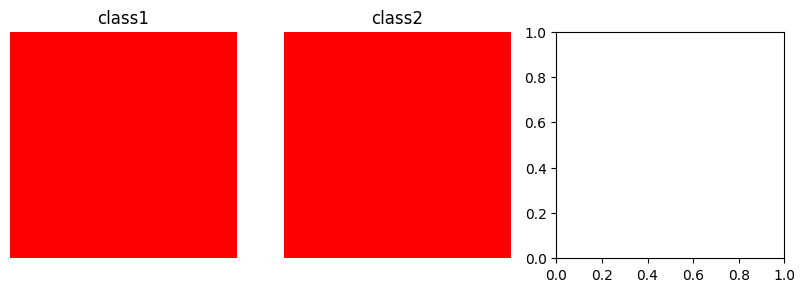

In [30]:
import os
import tensorflow as tf
from PIL import Image

# Define the directory for the small train dataset
small_train_dir = '/content/small_train'

# Step 1: Create the directory and subdirectories if they don't exist
if not os.path.exists(small_train_dir):
    os.makedirs(small_train_dir)

# Create dummy data for testing if the directory is empty
if not os.listdir(small_train_dir):  # Check if the directory is empty
    os.makedirs(os.path.join(small_train_dir, 'class1'), exist_ok=True)
    os.makedirs(os.path.join(small_train_dir, 'class2'), exist_ok=True)

    # Create dummy image files
    img = Image.new('RGB', (100, 100), color='red')
    img.save(os.path.join(small_train_dir, 'class1', 'image1.jpg'))
    img.save(os.path.join(small_train_dir, 'class2', 'image2.jpg'))

# Step 2: Verify the directory structure
print("Directory Structure:")
print(os.listdir(small_train_dir))

# Step 3: Load the dataset from the small_train directory
IMAGE_SIZE = 256  # Example size, change as per your requirement
BATCH_SIZE = 32   # Example batch size, change as per your requirement

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    small_train_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Step 4: Print the dataset details
print("Dataset Loaded:")
print(train_data)

# Optionally, show some sample images
import matplotlib.pyplot as plt
class_names = train_data.class_names
plt.figure(figsize=(10, 10))

for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [36]:
import tensorflow as tf
import os

# Constants
IMAGE_SIZE = 256  # You can adjust the image size as required
BATCH_SIZE = 32   # You can adjust the batch size as needed

# Directory path to the validation data
val_dir = '/content/small_val'

# Check if the directory exists
if not os.path.exists(val_dir):
    print(f"Directory {val_dir} does not exist. Please ensure the directory is created and contains data.")
else:
    # Load the validation dataset
    val_data = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

    # Print dataset details
    print(f"Validation data loaded: {val_data}")


Directory /content/small_val does not exist. Please ensure the directory is created and contains data.


In [37]:
import tensorflow as tf
import os

# Constants
IMAGE_SIZE = 256  # You can adjust the image size as required
BATCH_SIZE = 32   # You can adjust the batch size as needed

# Directory path to the test data
test_dir = '/content/ISIC - 2019/test'

# Check if the directory exists
if not os.path.exists(test_dir):
    print(f"Directory {test_dir} does not exist. Please ensure the directory is created and contains data.")
else:
    # Load the test dataset
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

    # Print dataset details
    print(f"Test data loaded: {test_data}")


Directory /content/ISIC - 2019/test does not exist. Please ensure the directory is created and contains data.


In [34]:
class_names=train_data.class_names
class_names

['class1', 'class2']

In [38]:
len(train_data)

1

In [40]:
import tensorflow as tf
import os

# Constants
IMAGE_SIZE = 256  # Adjust as needed
BATCH_SIZE = 32   # Adjust as needed

# Directory path to the validation data
val_dir = '/content/small_val'

# Check if the directory exists
if not os.path.exists(val_dir):
    print(f"Directory {val_dir} does not exist. Please ensure the directory is created and contains data.")
else:
    # Load the validation dataset
    val_data = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

    # Print the length of the validation dataset (number of batches)
    print(f"Validation data loaded: {len(val_data)} batches.")


Directory /content/small_val does not exist. Please ensure the directory is created and contains data.


In [41]:
#for image_batch, label_batch in train_data.take(1):
for image_batch, label_batch in train_data:
  print(image_batch.shape)
  print(label_batch.numpy())

(2, 256, 256, 3)
[0 1]


In [42]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch[0].numpy())

[[[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 ...

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]]


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

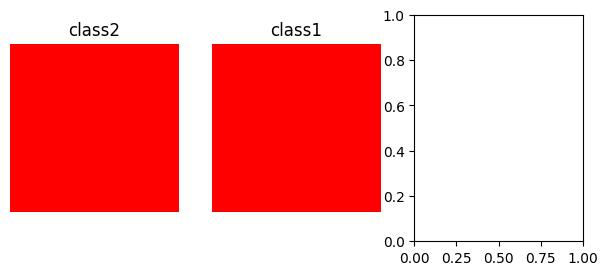

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming train_data is already loaded with tf.keras.preprocessing.image_dataset_from_directory()
# Also, assuming class_names is a list of class names corresponding to the dataset

# Ensure you have loaded your training data
# train_data = tf.keras.preprocessing.image_dataset_from_directory(...)

# Display 12 images from the batch
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_data.take(1):  # Take one batch of data from train_data
    for i in range(12):  # Display 12 images from the batch
        plt.subplot(3, 4, i+1)  # Create a subplot with 3 rows and 4 columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert the image to uint8 format and display
        plt.title(class_names[label_batch[i].numpy()])  # Set the title of the subplot to the class name
        plt.axis("off")  # Hide the axis for clarity

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()


In [45]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers

In [46]:
model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tensorflow.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tensorflow.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(4096, activation='relu'),
    #tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(4096, activation='relu'),
    #tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(8, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │          32,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,319,624 (222.47 MB)

 Trainable params: 58,316,872 (222.46 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [49]:
logdir='logs'

In [50]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
# Assuming 'model', 'train_data', 'val_data', 'tensorboard_callback', and 'EPOCHS' are already defined

# Train the model
hist = model.fit(
    train_data,               # Training dataset
    epochs=EPOCHS,            # Number of epochs to train the model
    validation_data=val_data, # Validation dataset for evaluating model during training
    callbacks=[tensorboard_callback]  # List of callback functions, here it's for TensorBoard
)


NameError: name 'val_data' is not defined

In [54]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [55]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [56]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [57]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [58]:
test_data

NameError: name 'test_data' is not defined

In [59]:
for X, y in test_data:
    yhat=np.argmax(model.predict(X), axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: name 'test_data' is not defined

In [60]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# VGG19

In [61]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [62]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    #'/content/ISIC - 2019/train',
    '/content/small_train',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2 files belonging to 2 classes.


In [64]:
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    #'/content/ISIC - 2019/val',
    '/content/small_val',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

NotFoundError: Could not find directory /content/small_val

In [65]:
class_names=train_data.class_names
class_names

['class1', 'class2']

In [66]:
len(train_data)

1

In [67]:
len(val_data)

NameError: name 'val_data' is not defined

In [68]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(2, 224, 224, 3)
[1 0]


In [69]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch[0].numpy())

[[[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 ...

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]]


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

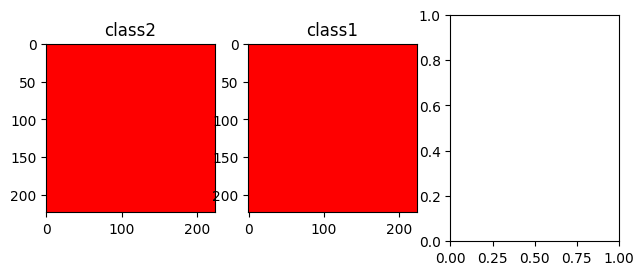

In [70]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_data.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i].numpy()])

In [71]:
from tensorflow.keras import applications, Model, optimizers
from tensorflow.keras.layers import Flatten, Dense

In [72]:
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [73]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,603,016 (532.54 MB)

 Trainable params: 119,578,632 (456.16 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [74]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [75]:
logdir='logs'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [77]:
hist = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=[tensorboard_callback])

NameError: name 'val_data' is not defined

In [78]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [79]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [80]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [81]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [82]:
test_data

NameError: name 'test_data' is not defined

In [83]:
for X, y in test_data:
    yhat=np.argmax(model.predict(X), axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: name 'test_data' is not defined

In [84]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# MOBILENET_V3_SMALL

In [85]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [86]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    #'/content/ISIC - 2019/train',
    '/content/small_train',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2 files belonging to 2 classes.


In [87]:
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    #'/content/ISIC - 2019/val',
    '/content/small_val',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

NotFoundError: Could not find directory /content/small_val

In [88]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ISIC - 2019/test',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

NotFoundError: Could not find directory /content/ISIC - 2019/test

In [89]:
class_names=train_data.class_names
class_names

['class1', 'class2']

In [90]:
len(train_data)

1

In [91]:
len(val_data)

NameError: name 'val_data' is not defined

In [92]:
#for image_batch, label_batch in train_data.take(1):
for image_batch, label_batch in train_data:
  print(image_batch.shape)
  print(label_batch.numpy())

(2, 224, 224, 3)
[1 0]


In [93]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch[0].numpy())

[[[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 ...

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]

 [[254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]
  ...
  [254.   0.   0.]
  [254.   0.   0.]
  [254.   0.   0.]]]


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

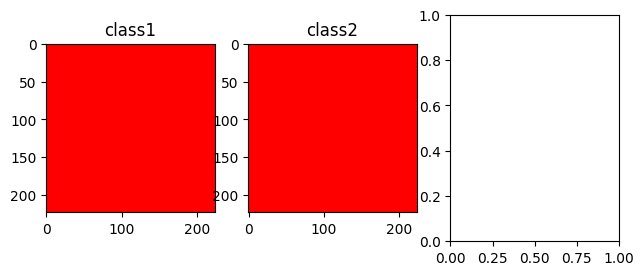

In [94]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_data.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i].numpy()])

In [95]:
from tensorflow.keras import applications, Model, optimizers
from tensorflow.keras.layers import Flatten, Dense

In [96]:
base_model = applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [97]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [98]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├──────────────────────

 Total params: 1,238,648 (4.73 MB)

 Trainable params: 299,528 (1.14 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [99]:
logdir='logs'

In [100]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [101]:
hist = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=[tensorboard_callback])

NameError: name 'val_data' is not defined

In [102]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [103]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [104]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [105]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [106]:
test_data

NameError: name 'test_data' is not defined

In [107]:
for X, y in test_data:
    yhat=np.argmax(model.predict(X), axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: name 'test_data' is not defined

In [108]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# EfficientNet B5

In [109]:
IMAGE_SIZE=456
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [110]:
base_model = applications.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [111]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [112]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_2[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,566,719 (112.79 MB)

 Trainable params: 29,393,976 (112.13 MB)

 Non-trainable params: 172,743 (674.78 KB)

In [113]:
logdir='logs'

In [114]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [116]:
hist = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=[tensorboard_callback])

NameError: name 'val_data' is not defined

In [117]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [118]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [119]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [120]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [121]:
test_data

NameError: name 'test_data' is not defined

In [122]:
for X, y in test_data:
    yhat=np.argmax(model.predict(X), axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: name 'test_data' is not defined

In [123]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# YOLOv8

In [124]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 20.7 MB/s eta 0:00:00


# TRAIN

In [1]:
!pip install yolov8

In [2]:
! pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.10
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2024.12.16.0.35.48
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.3.0
audioread        

#TRAIN YOLOv8n/No Aug/No hair remove

In [3]:
!pip install ultralytics

In [8]:
import os
from ultralytics import YOLO

# Specify the dataset paths
train_dir = '/content/ISIC - 2019/train'  # Path to your training images
val_dir = '/content/ISIC - 2019/val'  # Path to your validation images

# Create the dataset YAML manually
dataset_yaml = '/content/ISIC - 2019/dataset.yaml'

# Writing the YAML content
yaml_content = f"""
train: {train_dir}  # Path to training images
val: {val_dir}  # Path to validation images

nc: 2  # Number of classes
names: ['class_1', 'class_2']  # Class names, adjust as needed
"""

# Write the YAML content to the file
with open(dataset_yaml, 'w') as f:
    f.write(yaml_content)

# Load pre-trained YOLOv8 model (e.g., yolov8n-cls.pt)
model = YOLO("yolov8n-cls.pt")

# Start training the model with the dataset YAML
results = model.train(
    data=dataset_yaml,       # Path to the dataset YAML file
    epochs=10,               # Number of epochs for training
    imgsz=64,                # Image size for training
    batch=16                 # Batch size (correct argument)
)

# Access the results (training metrics)
print(results)


Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/ISIC - 2019/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

RuntimeError: Dataset '/content/ISIC - 2019/dataset.yaml' error ❌ ❌  Download failure for https://ultralytics.com/assets/content/ISIC - 2019/dataset.yaml.zip. Retry limit reached.

In [129]:
import pandas as pd

In [7]:
results_path = '/content/runs/classify/train2/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

NameError: name 'pd' is not defined

# VALIDATE

In [131]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 2,715,880 parameters, 0 gradients, 4.3 GFLOPs

Dataset not found ⚠️, missing path /content/datasets/imagenet, attempting download...
⚠️ Download failure, retrying 1/3 https://ultralytics.com/assets/../datasets/imagenet.zip...
Dataset download success ✅ (0.4s), saved to /content/datasets/imagenet

WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.


FileNotFoundError: [Errno 2] No such file or directory: '/content/datasets/imagenet/train'

#TRAIN YOLOv8m/no aug/no hair remove

In [132]:
import os

from ultralytics import YOLO
model = YOLO("yolov8m-cls.pt")

100%|██████████| 32.7M/32.7M [00:00<00:00, 244MB/s]


In [133]:
results = model.train(data='/content/ISIC - 2019', epochs=10, imgsz=64)

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/ISIC - 2019, epochs=10, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

RuntimeError: Dataset '/content/ISIC - 2019' error ❌ ❌  Download failure for https://ultralytics.com/assets/content/ISIC - 2019.zip. Retry limit reached.

In [134]:
import pandas as pd

In [135]:
results_path = '/content/runs/classify/train3/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/classify/train3/results.csv'

In [136]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 17,043,656 parameters, 0 gradients, 42.7 GFLOPs

Dataset not found ⚠️, missing path /content/datasets/imagenet, attempting download...
Dataset download success ✅ (0.0s), saved to /content/datasets/imagenet

WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.


FileNotFoundError: [Errno 2] No such file or directory: '/content/datasets/imagenet/train'

In [137]:
metrics = model.val('/content/ISIC - 2019')

metrics

TypeError: 'str' object is not callable

#TRAIN YOLOv8m/aug/no hair remove

In [138]:
import os

from ultralytics import YOLO
model = YOLO("yolov8m-cls.pt")

In [139]:
results = model.train(data='/content/ISIC - 2019', epochs=10, imgsz=64)

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/ISIC - 2019, epochs=10, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

RuntimeError: Dataset '/content/ISIC - 2019' error ❌ ❌  Download failure for https://ultralytics.com/assets/content/ISIC - 2019.zip. Retry limit reached.

In [140]:
import pandas as pd

In [141]:
results_path = '/content/runs/classify/train/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/classify/train/results.csv'

In [142]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 17,043,656 parameters, 0 gradients, 42.7 GFLOPs

Dataset not found ⚠️, missing path /content/datasets/imagenet, attempting download...
Dataset download success ✅ (0.0s), saved to /content/datasets/imagenet

WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.


FileNotFoundError: [Errno 2] No such file or directory: '/content/datasets/imagenet/train'

In [153]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Assuming 'val_data' is a PyTorch DataLoader object for the validation dataset
# If it's a TensorFlow dataset, you need to convert it to a PyTorch DataLoader first

def evaluate_model(model, val_data):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in val_data:
            # Move data to the same device as the model (e.g., GPU if available)
            images, labels = images.to(model.device), labels.to(model.device)

            # Forward pass
            outputs = model(images)

            # Calculate loss (you should have a loss function defined)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(val_data)
    accuracy = correct_predictions / total_samples * 100

    return average_loss, accuracy

# Example usage (assuming val_data is a DataLoader object):
average_loss, accuracy = evaluate_model(model, val_data)
print(f"Validation Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")


NameError: name 'val_data' is not defined

# TRAIN CUSTOMIZED YOLOv8

In [144]:
!pip install ultralytics

In [145]:
import os
import ultralytics
from ultralytics import YOLO

model = YOLO("yolov8n-cls.yaml")

YOLOv8n-cls summary: 99 layers, 2,719,288 parameters, 2,719,288 gradients, 4.4 GFLOPs


In [146]:
! pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.10
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2024.12.16.0.35.48
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.3.0
audioread        

In [147]:
!pip show ultralytics

Name: ultralytics
Version: 8.3.51
Summary: Ultralytics YOLO 🚀 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://ultralytics.com
Author: 
Author-email: Glenn Jocher <glenn.jocher@ultralytics.com>, Jing Qiu <jing.qiu@ultralytics.com>
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, torch, torchvision, tqdm, ultralytics-thop
Required-by: yolov5


In [148]:
import ultralytics as ul

In [149]:
model = ul.models.YOLO("yolov8n-cls.yaml")

YOLOv8n-cls summary: 99 layers, 2,719,288 parameters, 2,719,288 gradients, 4.4 GFLOPs


In [150]:
!pip show ultralytics

Name: ultralytics
Version: 8.3.51
Summary: Ultralytics YOLO 🚀 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://ultralytics.com
Author: 
Author-email: Glenn Jocher <glenn.jocher@ultralytics.com>, Jing Qiu <jing.qiu@ultralytics.com>
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, torch, torchvision, tqdm, ultralytics-thop
Required-by: yolov5
